**Описание проекта** <br>
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. 
То есть клиенты предлагают свои правки и комментируют изменения других. 
Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn import feature_selection 

from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from itertools import chain
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle
from sklearn.utils import resample

from sklearn import feature_extraction, model_selection, pipeline, manifold, preprocessing 
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
import re 

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

import time
import warnings
warnings.filterwarnings('ignore')

**Подготовка данных**

In [2]:
try:
    data = pd.read_csv('C:\\Python\\datasets\\toxic_comments.csv') 
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.shape

(159292, 3)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
# Удалим столбец Unnamed:
data = data.drop(['Unnamed: 0'], axis=1)

In [7]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [8]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [9]:
data["text_clean"] = data["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
data.head()

,text,toxic,text_clean
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,daww match background colour im seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,cant make real suggestion improvement wondered...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats


**Вывод:** <br>
Загрузили данные. Провели очистку и леммизацию текста.

**Split Dataset**

In [10]:
target = data['toxic']
features = data.drop('toxic', axis=1)

In [11]:
X_train0, X_test0, y_train0, y_test = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=True,stratify=target)

**Соотношение классов в целевом признаке и балансировка классов**

In [12]:
print('-Соотношение классов в целевом признаке-')
display(target.value_counts())
target_class_ratio = target.value_counts()[0] / target.value_counts()[1]

-Соотношение классов в целевом признаке-


0    143106
1     16186
Name: toxic, dtype: int64

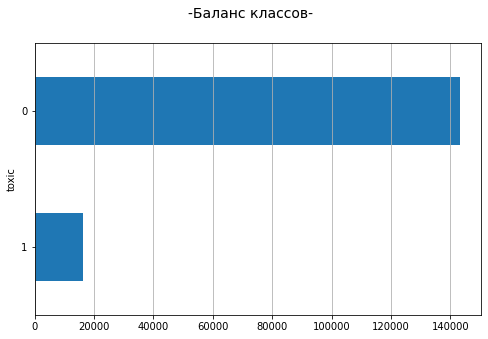

In [13]:
fig, ax = plt.subplots()
fig.suptitle('-Баланс классов-', fontsize=14)
target.reset_index().groupby('toxic').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, figsize=(8, 5),
        ax=ax).grid(axis='x')
plt.show()

In [14]:
def down_up_sample(features, target, fraction, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_down_up = pd.concat([features_zeros.sample(frac=fraction, random_state=42)] + [features_ones]*repeat)
    target_down_up = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] + [target_ones]*repeat)
    
    features_down_up_sampled, target_down_up_sampled = shuffle(
        features_down_up, target_down_up, random_state=12345)
    
    return features_down_up_sampled, target_down_up_sampled

X_train1, y_train  = down_up_sample(X_train0, y_train0, 0.8, 7)

In [15]:
print('-Соотношение классов в целевом признаке после применения upsample и downsample-')
display(y_train.value_counts())
target_class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

-Соотношение классов в целевом признаке после применения upsample и downsample-


0    80139
1    79310
Name: toxic, dtype: int64

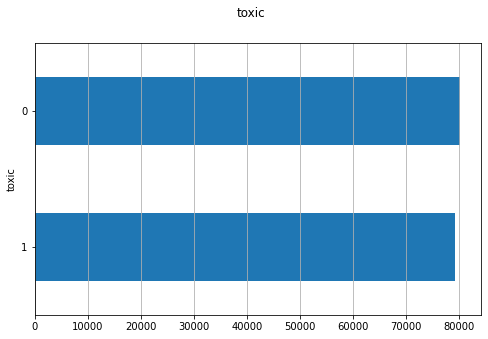

In [16]:
fig, ax = plt.subplots()
fig.suptitle('toxic', fontsize=12)
y_train.reset_index().groupby('toxic').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, figsize=(8, 5),
        ax=ax).grid(axis='x')
plt.show()

**Вывод:** <br>
Проверили соотношение классов в целевом признаке на наличие баланса. Обнаружили, что классы разбанлансированы. Произвели балансировку классов с помощью технологии upsample и downsample. 

**TF-IDF Vectorizer**

In [17]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=500000, ngram_range=(1,2))

In [18]:
#-Трансформируем обучающую выборку-
corpus = X_train1["text_clean"]
X_train = vectorizer.fit_transform(corpus)
display(X_train.shape)

(159449, 500000)

In [19]:
#-Трансформируем тестовую выборку-
corpus_test = X_test0["text_clean"]
X_test = vectorizer.transform(corpus_test)
display(X_test.shape)

(47788, 500000)

In [20]:
y =  y_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()
len(X_names)

11070

In [21]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# 0:
  . selected features: 11070
  . top features: add,added,adding,agree,also,article,as,asshole,ball,bastard
 
# 1:
  . selected features: 11070
  . top features: add,added,adding,agree,also,article,as,asshole,ball,bastard
 


**Naive Bayes Model**

In [22]:
model1 = naive_bayes.MultinomialNB()
parameters = {'alpha':[1, 5,
10, 50, 100]}
clf = GridSearchCV(model1, parameters, cv=10, scoring='f1',return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [1, 5, 10, 50, 100]}, return_train_score=True,
             scoring='f1')

In [23]:
results = pd.DataFrame.from_dict(clf.cv_results_)   
results = results.sort_values(['param_alpha'])  

In [24]:
train_auc= results['mean_train_score'].values   
cv_auc = results['mean_test_score'].values

In [25]:
a1=[]
for i in parameters.values():
    a1.append(i)
alphas = list(chain.from_iterable(a1))

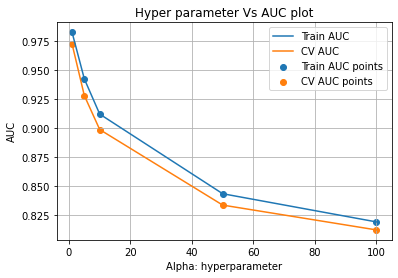

In [26]:
plt.plot(alphas, train_auc, label='Train AUC')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")  
plt.grid()
plt.show()

In [27]:
bestparam=clf.best_params_['alpha']    
print("The best Alpha=",bestparam)

The best Alpha= 1


In [28]:
model11 = naive_bayes.MultinomialNB(alpha=bestparam)  
model11.fit(X_train, y_train)

MultinomialNB(alpha=1)

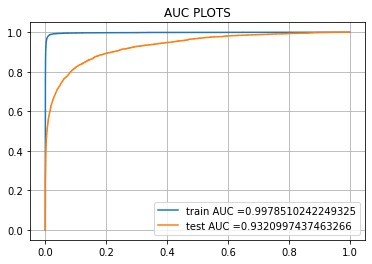

In [29]:
y_train_pred = model11.predict_proba(X_train)[:,1]   
y_test_pred = model11.predict_proba(X_test)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)   
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.title("AUC PLOTS")              
plt.grid()
plt.show()

In [30]:
trauc=round(auc(train_fpr, train_tpr),3)
teauc=round(auc(test_fpr, test_tpr),3)
print('Train AUC=',trauc)
print('Test AUC=',teauc)

Train AUC= 0.998
Test AUC= 0.932


**Вывод:**<br>
Получили AUC score обе для тестовой и тренировочной выборок > 0.8. <br>
Это значит, что модель работает хорощо. <br>

In [31]:
#-Поиск лучшего порога-
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]      
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:                                  
            predictions.append(0)
    return predictions

In [32]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
TRCM=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
TECM=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.9729288267636746 for threshold 0.597


In [33]:
def CM(x,y):
    labels = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in x.flatten()]
                    
    labels = [f"{v1}\n{v2}" for v1, v2 in
    zip(labels,group_counts)]
    labels = np.asarray(labels).reshape(2,2)        
    sns.heatmap(x, annot=labels, fmt='', cmap='BuPu')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(y)
    plt.plot()

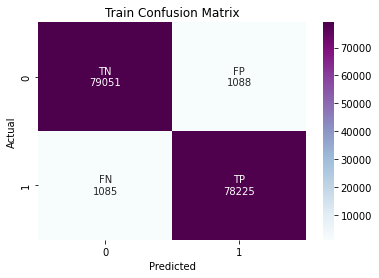

In [34]:
CM(TRCM,'Train Confusion Matrix')

У нас больше истинных положительных предсказаний и истинных отрицательных. <br>
Что означает, что больше классов было классифицировано правильно. <br>
То же самое можно наблюдать в матрице спутанности для тестовой выборки.

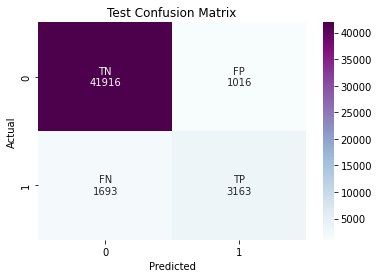

In [35]:
CM(TECM,'Test Confusion Matrix')

In [36]:
predicted = predict_with_best_t(y_test_pred, best_t)

In [37]:
f1 = f1_score(y_test, predicted)
f1

0.7001660210293303

**LogisticRegression**

In [44]:
clf_lr = LogisticRegression(random_state=42, solver='sag',class_weight='balanced')
parametrs_lr = { 'C': range (1, 14),
              'max_iter': range (10,15,2),
              }
grid_lr = GridSearchCV(clf_lr, parametrs_lr, cv=3, scoring='f1')
grid_lr.fit(X_train, y_train)
grid_lr.best_params_

{'C': 13, 'max_iter': 14}

In [45]:
predicted= grid_lr.predict(X_test)

In [46]:
f1 = f1_score(y_test, predicted)
f1

0.7803271722965796

**DecisionTreeClassifier**

In [41]:
param_grid = {
    'min_samples_split': [10, 20, 35],
    'min_samples_leaf': [1,2],
    'max_features': ['auto']
}

model4 = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model4, param_grid=param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)

model4 = grid_search.best_estimator_

Best parameters: {'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10}


In [42]:
predicted= grid_search.predict(X_test)

In [43]:
f1 = f1_score(y_test, predicted)
f1

0.48071979434447304

**Вывод:** <br>
Загрузили текст. Провели предобработку: Провели очистку и леммизацию текста. Проверили соотношение классов в целевом признаке на наличие баланса. Обнаружили, что классы разбалансированы. Произвели балансировку классов с помощью технологии upsample и downsample. Трансформируем обучающую и тестовую выбоки выборку с помощью алгоритма TF-IDF Vectorizer - извлекаем признаки из текста. <br>
Обучили и исследовали три модели: <br>
Naive Bayes Model, <br>
LogisticRegression, <br>
DecisionTreeClassifier. <br>
Лучший результат на тестовой выборке показала модель LogisticRegression с f1 = 0.78. <br>
Цель проекта достигнута. Построена модель со значением метрики качества F1 не меньше 0.75.